In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from google.colab import files

uploaded = files.upload()

Saving 202501_기준금속.xlsx to 202501_기준금속.xlsx


In [4]:
# 데이터 불러오기
df = pd.read_excel('202501_기준금속.xlsx')

In [5]:
# 날짜 컬럼 datetime 변환
df['Pump-Begin'] = pd.to_datetime(df['Pump-Begin'], errors='coerce')

In [6]:
# 금속 컬럼 추출 (ng/m3)
metal_columns = [col for col in df.columns if '(ng/m3)' in col]

In [13]:
# 금속 음수값 NaN 처리
for c in metal_columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df[metal_columns] = df[metal_columns].mask(df[metal_columns] < 0)

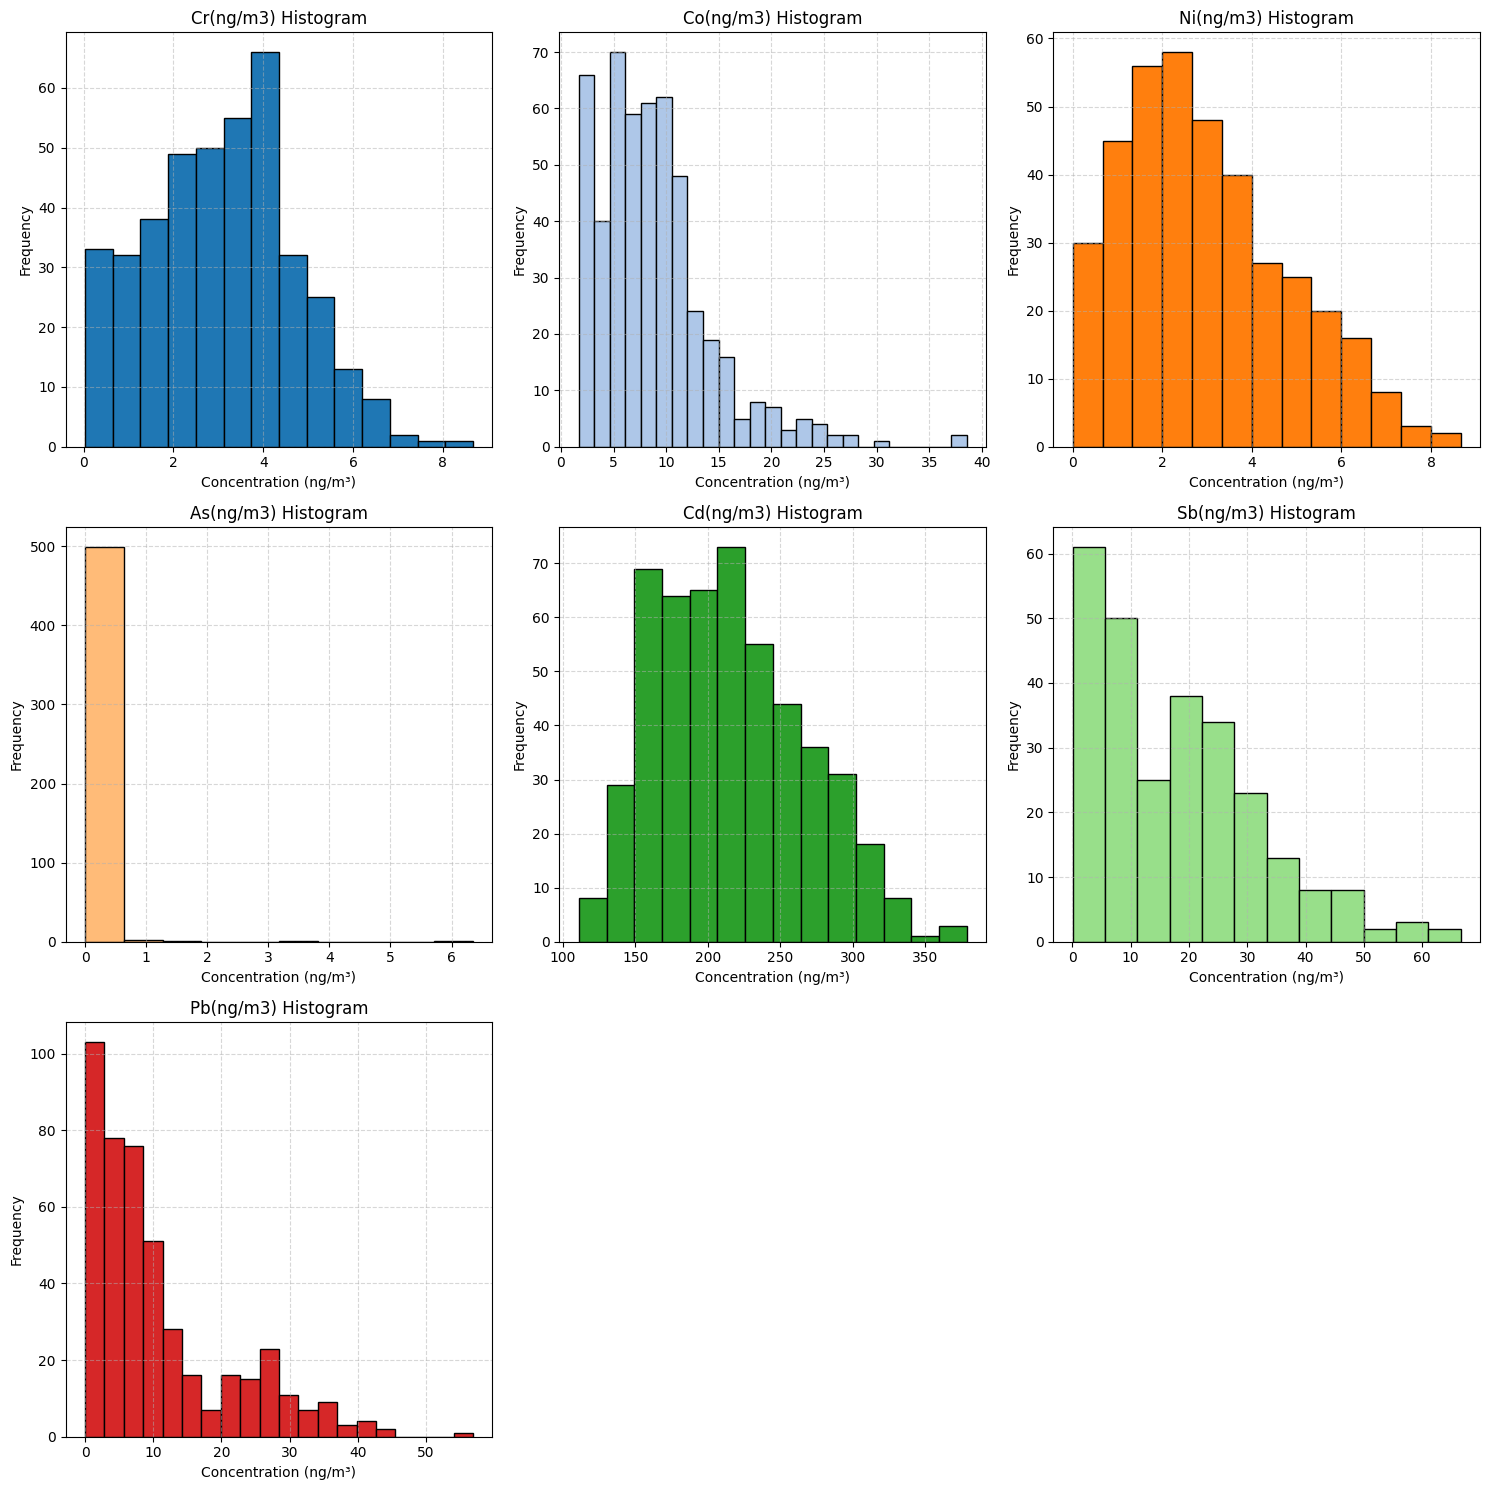

In [14]:
# 히스토그램 생성 전 설정
num_metals = len(metal_columns) # 금속 개수
cols = 3 # subplot 열 개수
rows = math.ceil(num_metals / cols) # subplot 행 개수 계산
colors = plt.cm.tab20.colors # 색상 팔레트

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows)) # 전체 subplot 틀 생성
axes = axes.flatten()  # 반복문 단일 인덱스로 변경

# subplot 반복 생성
for idx, metal in enumerate(metal_columns):
    data = df[metal].dropna()

    # 유효한 값이 1개 이하이거나, 모두 같은 값인 경우 (예: 전부 0)
    if data.nunique() <= 1:
        axes[idx].axis('off') # x, y축 off
        axes[idx].text(0.5, 0.5, f'{metal}\nNo meaningful data',
                       horizontalalignment='center',
                       verticalalignment='center',
                       fontsize=15,
                       transform=axes[idx].transAxes,
                       bbox=dict(facecolor='lightgray', edgecolor='gray'))
        continue

    color_idx = idx % len(colors)  # 색상 순환 사용
    axes[idx].hist(df[metal].dropna(), # 히스토그램 생성
                   bins='auto', # bin 개수 자동 설정
                   edgecolor='black',
                   color=colors[color_idx])
    axes[idx].set_title(f"{metal} Histogram")
    axes[idx].set_xlabel("Concentration (ng/m³)")
    axes[idx].set_ylabel("Frequency")
    axes[idx].grid(True, linestyle='--', alpha=0.5)

# 남는 subplot 칸은 숨김 처리
for ax in axes[num_metals:]:
    ax.set_visible(False)

# 그래프 출력
plt.tight_layout()
plt.show()

In [28]:
# 금속 컬럼 추출 (ng/m3)
target_metals = ["Cr(ng/m3)", "Co(ng/m3)", "Ni(ng/m3)",
                 "As(ng/m3)", "Cd(ng/m3)", "Sb(ng/m3)", "Pb(ng/m3)"]

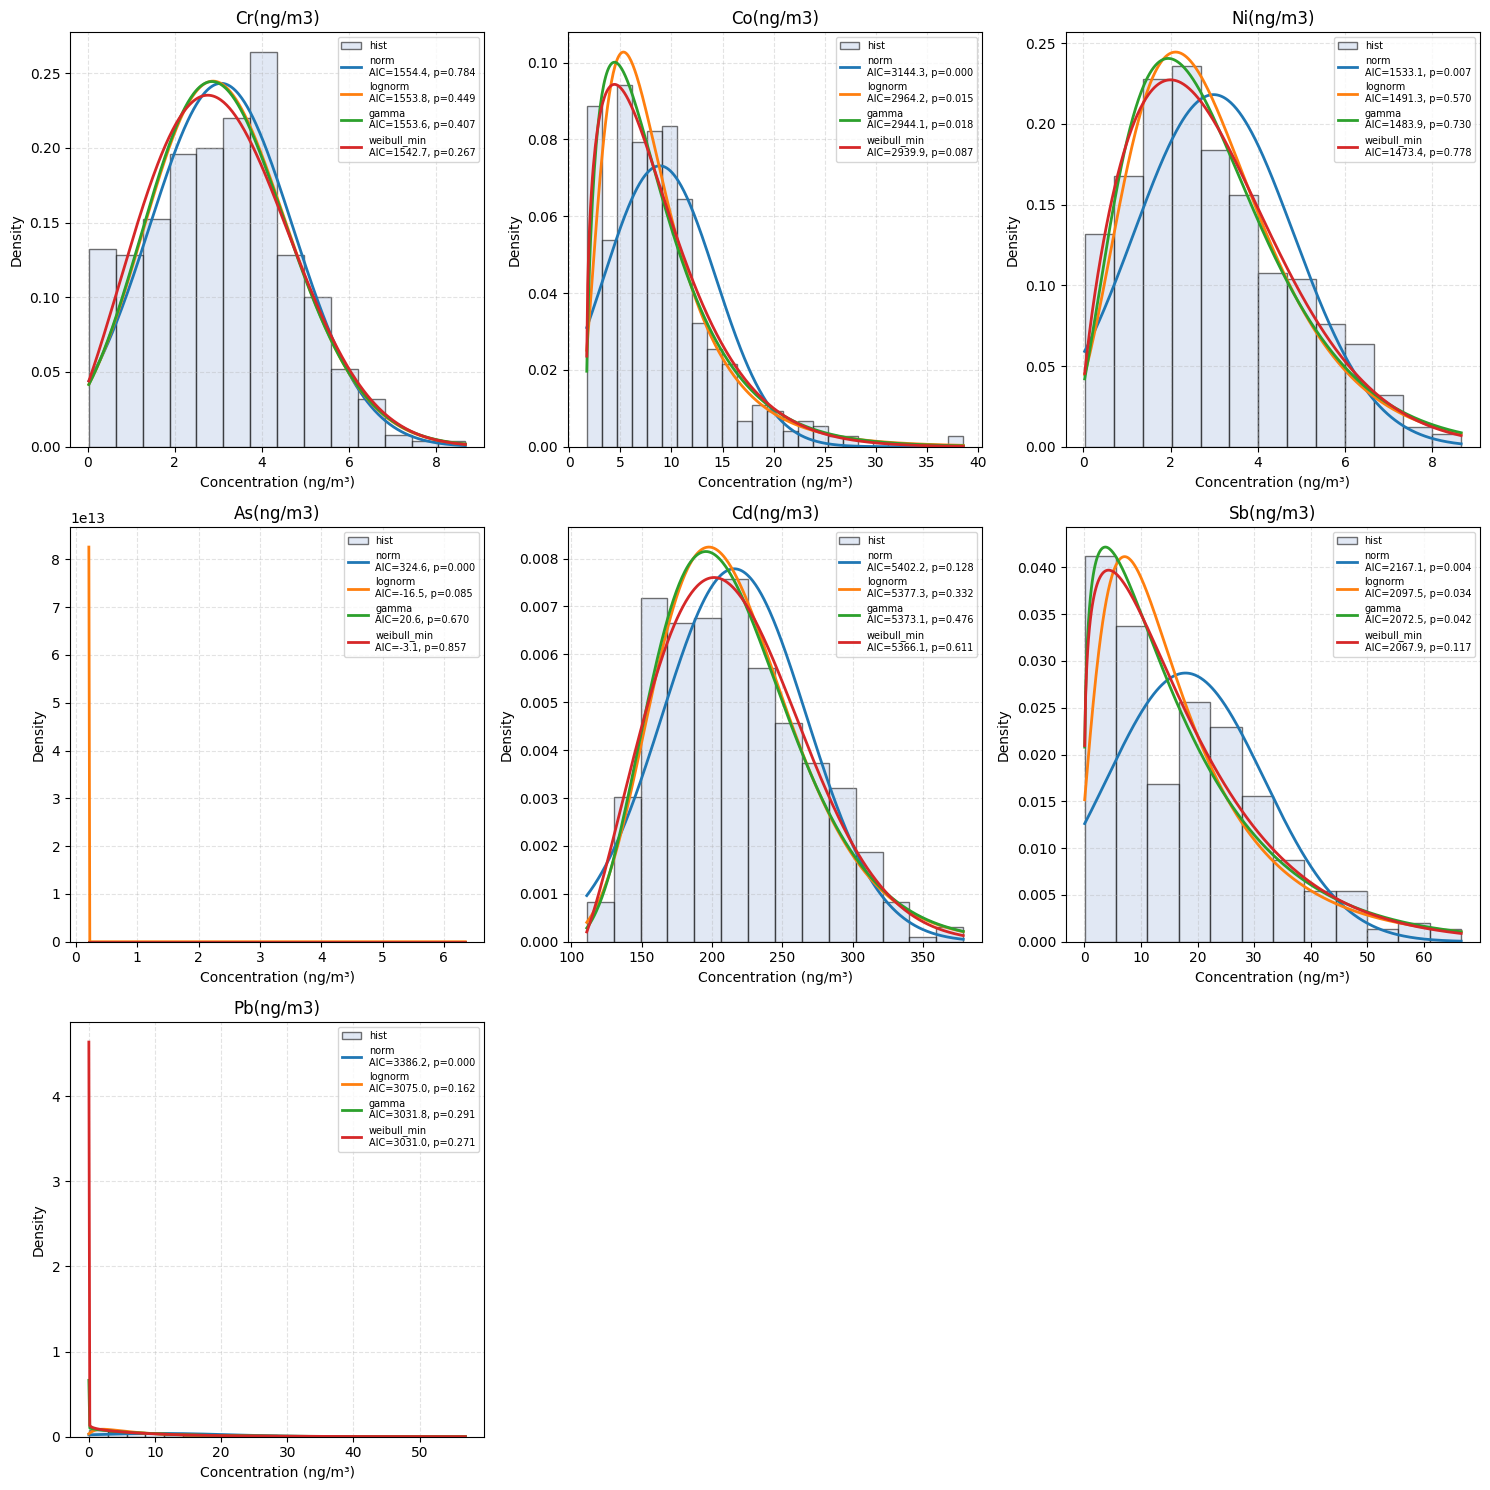

In [36]:
# subplot 구조 설정
cols = 3
rows = math.ceil(len(target_metals) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for idx, metal in enumerate(target_metals):
    ax = axes[idx]

    if metal not in df.columns:
        ax.axis("off")
        ax.text(0.5, 0.5, f"{metal}\nNo column", ha="center", va="center")
        continue

    s = df[metal]
    if pd.to_numeric(s, errors="coerce").dropna().nunique() <= 1:
        ax.axis("off")
        ax.text(0.5, 0.5, f"{metal}\nNo data", ha="center", va="center")
        continue

    # 히스토그램용 데이터
    data_all = pd.to_numeric(s, errors="coerce").dropna().values
    data_pos = data_all[data_all > 0]
    hist_data = data_pos if data_pos.size >= 5 else data_all

    if hist_data.size < 5:
        ax.axis("off")
        ax.text(0.5, 0.5, f"{metal}\nToo few data", ha="center", va="center")
        continue

    # 히스토그램
    ax.hist(hist_data, bins="auto", density=True,
            alpha=0.55, color="#c9d6eb", edgecolor="black", label="hist")

    # 분포 피팅 및 PDF 곡선 추가
    metal_res = fit_results.get(metal, {})
    x = np.linspace(hist_data.min(), hist_data.max(), 400)

    for dist_name, res in metal_res.items():
        # stats 객체 얻기
        dist = getattr(stats, dist_name)
        pdf = dist.pdf(x, *res["params"])
        pdf = np.where(np.isfinite(pdf), pdf, 0.0)
        ax.plot(x, pdf, lw=2,
                label=f"{dist_name}\nAIC={res['AIC']:.1f}, p={res['KS_p']:.3f}")

    ax.set_title(metal)
    ax.set_xlabel("Concentration (ng/m³)")
    ax.set_ylabel("Density")
    ax.grid(True, ls="--", alpha=0.35)
    ax.legend(fontsize=7)

    # 남는 subplot은 숨김
for ax in axes[len(target_metals):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

In [29]:
# 단일 분포 피팅 함수
def fit_one_series(series: pd.Series, dist):

    # 1) 숫자화 및 결측 제거
    data_all = pd.to_numeric(series, errors="coerce").dropna().values
    n_all = data_all.size
    if n_all < 5:
        return None  # 표본 너무 적으면 피팅 생략

    # 2) 분포 지지 처리
    # 로그정규/감마/와이블은 양수만 허용, 0 이하는 제외
    positive_support = dist in (stats.lognorm, stats.gamma, stats.weibull_min)
    data = data_all[data_all > 0] if positive_support else data_all
    n = data.size
    if n < 5:
        return None

    # 3) 파라미터 추정
    params = dist.fit(data)

    # 4) KS 검정 (데이터가 해당 분포에서 왔는지)
    D, p = stats.kstest(data, dist.name, args=params)

    # 5) 로그우도 LL = sum(logpdf) (수치 안정성 처리)
    logpdf = dist.logpdf(data, *params)
    logpdf = np.where(np.isfinite(logpdf), logpdf, -1e300)
    LL = float(np.sum(logpdf))

    # 6) 정보기준 (모수 개수 k = params 길이)
    k = len(params)
    AIC = 2 * k - 2 * LL
    BIC = k * np.log(n) - 2 * LL

    return {"n_all": int(n_all), # 원 표본 수
            "n_used": int(n),    # 실제 피팅 사용 표본 수
            "params": params,
            "KS_D": D,
            "KS_p": p,
            "LL": LL,
            "AIC": AIC,
            "BIC": BIC}

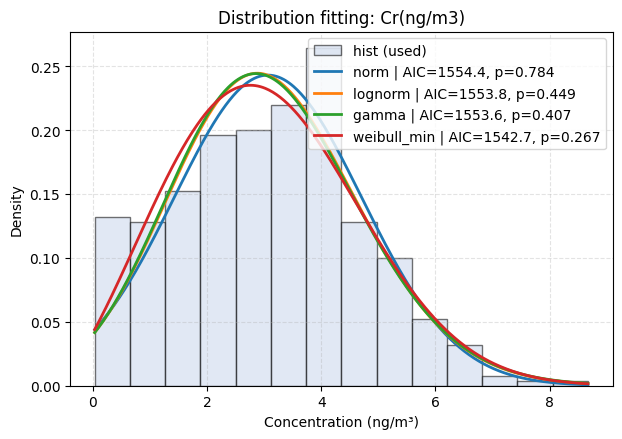

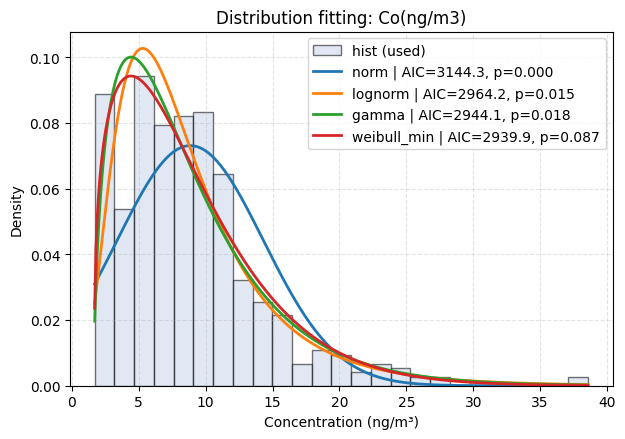

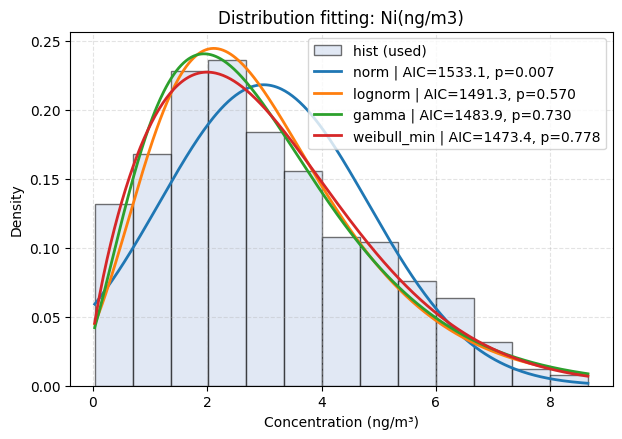

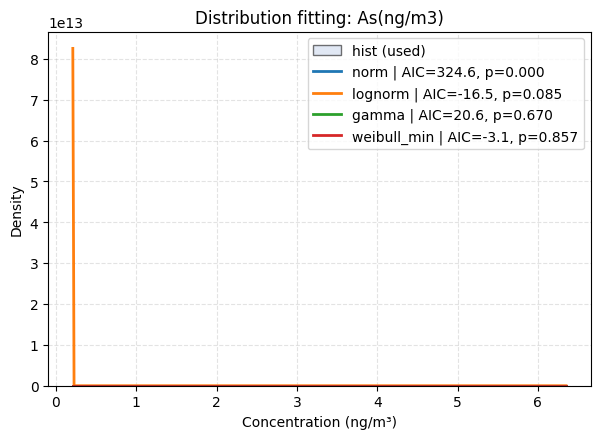

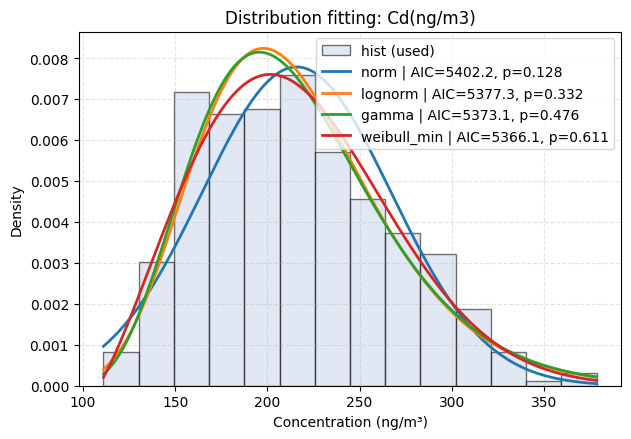

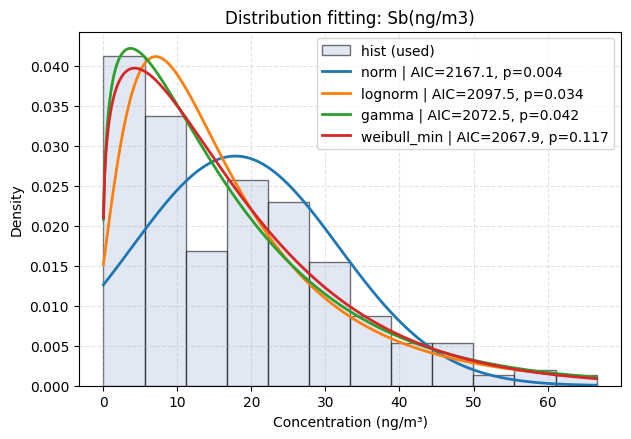

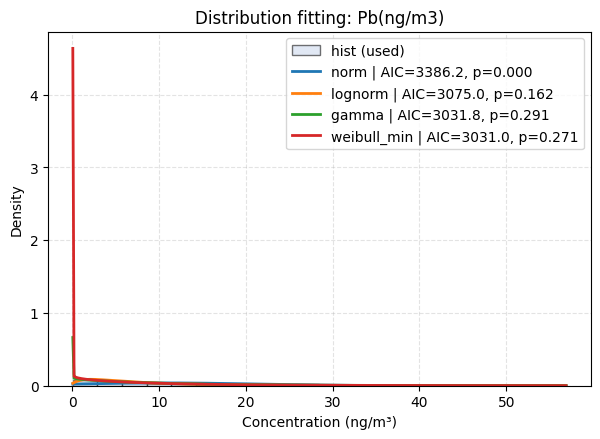

In [30]:
# 전체 금속에 대해 4개 분포 비교
distributions = [stats.norm, stats.lognorm, stats.gamma, stats.weibull_min]
fit_results = {}  # { metal: { dist_name: result_dict } }

for metal in target_metals:
    if metal not in df.columns:
        print(f"[SKIP] {metal}: 컬럼이 존재하지 않음")
        continue

    s = df[metal]
    if pd.to_numeric(s, errors="coerce").dropna().nunique() <= 1:
        print(f"[SKIP] {metal}: 분산 부족으로 피팅 생략")
        continue

    metal_res = {}
    for dist in distributions:
        res = fit_one_series(s, dist)
        if res is not None:
            metal_res[dist.name] = res
    fit_results[metal] = metal_res

    # 시각화: 히스토그램 및 PDF 곡선 오버레이
    data_all = pd.to_numeric(s, errors="coerce").dropna().values
    data_pos = data_all[data_all > 0]
    # 양의 지지 분포가 포함되므로, 시각화는 양수 데이터로 맞추는 것이 해석이 쉬움
    hist_data = data_pos if data_pos.size >= 5 else data_all

    if hist_data.size >= 5:
        plt.figure(figsize=(7, 4.6))
        plt.hist(hist_data, bins="auto", density=True,
                 alpha=0.55, color="#c9d6eb", edgecolor="black", label="hist (used)")
        x = np.linspace(hist_data.min(), hist_data.max(), 400)

        for dist_name, res in metal_res.items():
            dist = getattr(stats, dist_name)
            pdf = dist.pdf(x, *res["params"])
            pdf = np.where(np.isfinite(pdf), pdf, 0.0)
            plt.plot(x, pdf, lw=2, label=f"{dist_name} | AIC={res['AIC']:.1f}, p={res['KS_p']:.3f}")

        plt.title(f"Distribution fitting: {metal}")
        plt.xlabel("Concentration (ng/m³)")
        plt.ylabel("Density")
        plt.grid(True, ls="--", alpha=0.35)
        plt.legend()
        plt.show()

In [27]:
# 요약표 생성
rows = []
for metal, mres in fit_results.items():
    for dist_name, res in mres.items():
        rows.append({"Metal": metal,
                     "Distribution": dist_name,
                     "n_all": res["n_all"],
                     "n_used": res["n_used"],
                     "KS_D": res["KS_D"],
                     "KS_p": res["KS_p"],
                     "AIC": res["AIC"],
                     "BIC": res["BIC"]})

summary = pd.DataFrame(rows)
if not summary.empty:
    # 금속별 최적(AIC 최소) 식별
    summary["AIC_rank"] = summary.groupby("Metal")["AIC"].rank(method="first")
    summary_sorted = summary.sort_values(["Metal", "AIC"]).reset_index(drop=True)

    print("\n=== Fit summary (sorted by AIC) ===")
    print(summary_sorted.to_string(index=False))

# 엑셀 저장
    out_name = "Metal_Fit_Summary.xlsx"
    with pd.ExcelWriter(out_name, engine="openpyxl") as w:
        summary_sorted.to_excel(w, sheet_name="summary_by_AIC", index=False)
    files.download(out_name)
else:
    print("요약표를 만들 충분한 피팅 결과가 없습니다.")


=== Fit summary (sorted by AIC) ===
    Metal Distribution  n_all  n_used     KS_D          KS_p         AIC         BIC  AIC_rank
As(ng/m3)      lognorm    504       6 0.480286  8.531037e-02  -16.488225  -17.112946       1.0
As(ng/m3)  weibull_min    504       6 0.226539  8.572218e-01   -3.072670   -3.697392       2.0
As(ng/m3)        gamma    504       6 0.273614  6.696287e-01   20.645421   20.020699       3.0
As(ng/m3)         norm    504     504 0.519598 4.459326e-127  324.590075  333.035228       4.0
Cd(ng/m3)  weibull_min    504     504 0.033499  6.114778e-01 5366.052925 5378.720654       1.0
Cd(ng/m3)        gamma    504     504 0.037224  4.760266e-01 5373.142047 5385.809775       2.0
Cd(ng/m3)      lognorm    504     504 0.041813  3.323482e-01 5377.285315 5389.953044       3.0
Cd(ng/m3)         norm    504     504 0.051889  1.279377e-01 5402.213221 5410.658373       4.0
Co(ng/m3)  weibull_min    504     504 0.055425  8.706157e-02 2939.862599 2952.530328       1.0
Co(ng/m3)    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>